### Mkhanyisi Gamedze
#### COSI 165B Deep Learning
#### Term Project Analysis - Google Cloud
#### 10 May 2022



DataSet link: https://competitions.codalab.org/competitions/4081#participate-get-data or https://chalearnlap.cvc.uab.cat/dataset/17/description/

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy import ndimage, misc
import imageio
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models as models

from tqdm import tqdm

### Load Data

Build labels Dataframe

<b>Train Labels</b>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
r="/content/drive/MyDrive/COSI 165B data"
os.chdir(r)
print(os.getcwd())

/content/drive/MyDrive/COSI 165B data


### Load saved data

In [4]:
os.chdir(r)
print(os.getcwd())
os.listdir()

/content/drive/MyDrive/COSI 165B data


['reencoded_smallerdataY.npy', 'smallerdataX.npy']

In [5]:
#os.chdir('./Numpy Clean Dataset')

In [2]:
fulldataX=np.load('smallerdataX.npy')

fulldataX.shape

(2254, 256, 256, 3)

In [3]:
fulldataY=np.load('reencoded_smallerdataY.npy')
fulldataY.shape

(2254, 1)

<b>Test Transform</b>

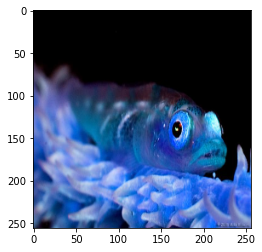

In [4]:
plt.imshow(fulldataX[1])
plt.show()

In [9]:
fulldataY.shape

(2254, 1)

#### To Tensor

In [10]:
tensordataX = torch.FloatTensor(fulldataX)

tensordataY = torch.FloatTensor(fulldataY.astype(int))


tensordataX.shape, tensordataY.shape

(torch.Size([2254, 256, 256, 3]), torch.Size([2254, 1]))

<b>Permute Images so input channel is color for convolution</b>

In [11]:
tensordataX=tensordataX.permute(0,3,1,2)
tensordataX.shape

torch.Size([2254, 3, 256, 256])

### Train-Test split (80 : 20)

In [12]:
p=int(0.8*(tensordataX.shape[0]))

trainX=tensordataX[:p]
testX=tensordataX[p:]
trainY=tensordataY[:p]
testY=tensordataY[p:]

trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([1803, 3, 256, 256]),
 torch.Size([1803, 1]),
 torch.Size([451, 3, 256, 256]),
 torch.Size([451, 1]))

### Vanilla CNN model

In [13]:
# CNN model
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        
        # define convolution layers
        """
        self.conv1 = nn.Conv2d(3, 96, kernel_size=(7,7), stride=2)
        self.conv2 = nn.Conv2d(96, 512, kernel_size=(3,3), stride=1)
        """
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5,5), stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5,5), stride=1)
        
        
        # figure out output conv flat length
        x = torch.randn(1,3,256,256)
        self._to_linear = None
        self.convs(x)
        
        # fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 500)
        self.fc2 = nn.Linear(500,250)
        self.fc3 = nn.Linear(250, 11)
        self.softmax = nn.Softmax(dim=1)

        
    def convs(self, x):
        # max pooling over 2x2 both Conv layers
        x=self.conv1(x)
        x=F.relu(x)
        x =F.max_pool2d(x, (2, 2))
        
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        
        #print(x.shape)
        # first pass, figure flat length
        if self._to_linear is None:
            print("x[0] : ",x[0].shape)
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x) # first two convolutional layers
        x = x.reshape(-1, self._to_linear) # flatten x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.sigmoid(self.fc3(x)) # Sigmoidal activation for output layer since two class problem
        x=F.log_softmax(self.fc3(x), dim=1)
        
        #x=self.softmax(self.fc3(x))
        #print("x:",x.shape)
        #print("x:",x)
        return x

In [14]:
vanillaCNN=Net()

x[0] :  torch.Size([16, 61, 61])


In [15]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device "%s" for training' % dev)

Using device "cuda" for training


In [16]:
vanillaCNN.to(dev)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=11, bias=True)
  (softmax): Softmax(dim=1)
)

In [17]:
#transform = torchvision.transforms.ToTensor()
img=trainX[:19].cuda()
print("image shape: ",img.shape)
print("reshaped img: ",img.view(-1,3,256,256).shape)

v=torch.randn(1,3,256,256).cuda()
print("v shape: ",v.shape)
r=vanillaCNN.forward(v)
simg=torch.squeeze(img.view(-1,3,256,256))
print("squezzed img: ",simg.shape)


im= torch.rand(10, 3, 256,256).cuda()
print("rand tensor shape: ",im.shape)
c=vanillaCNN.forward(im)

print("output: ",r)
print("rand img output: ",c.shape)

image shape:  torch.Size([19, 3, 256, 256])
reshaped img:  torch.Size([19, 3, 256, 256])
v shape:  torch.Size([1, 3, 256, 256])
squezzed img:  torch.Size([19, 3, 256, 256])
rand tensor shape:  torch.Size([10, 3, 256, 256])
output:  tensor([[-2.3568, -2.4042, -2.3874, -2.3507, -2.2883, -2.4255, -2.4435, -2.3915,
         -2.4236, -2.4914, -2.4286]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
rand img output:  torch.Size([10, 11])


In [18]:
b=vanillaCNN.forward(img)
print("batch result: ",b.shape)

batch result:  torch.Size([19, 11])


In [19]:
print("CNN Model:\n",vanillaCNN)

CNN Model:
 Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=11, bias=True)
  (softmax): Softmax(dim=1)
)


#### Train model

In [20]:
EPOCHS = 40
BATCH_SIZE = 100

In [21]:
min_loss = np.Inf #lowest loss will be the loaded model

loss_function = nn.CrossEntropyLoss().to(dev) 

optimizer = optim.Adam(vanillaCNN.parameters(),lr=0.00001)

epoch_num=[]
loss_arr=[]

enum=0
for epoch in range(EPOCHS):
    train_loss = 0
    vanillaCNN.train()
    for i in tqdm(range(0, len(trainX), BATCH_SIZE)): 
        #print(f"{i}:{i+BATCH_SIZE}")
        
        batch_X = trainX[i:i+BATCH_SIZE].to(dev)
        batch_y = trainY[i:i+BATCH_SIZE].to(dev)
        batch_y=batch_y.view(len(batch_y)).type(torch.LongTensor)
        
        vanillaCNN.zero_grad()
        #print("batch shape: ",batch_X.shape)
        batch_X=batch_X.cuda()
        batch_y=batch_y.cuda()

        outputs = vanillaCNN(batch_X)
        outputs.to(dev)
        #print("result shape: ",outputs.shape,batch_y.shape)
        
        #print(outputs.dtype)
        #print(batch_y.dtype)
        #print(outputs.shape," <=> ",batch_y.shape)
        
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    #update weights
        
        #print(loss.item())
        #print(loss.item()," - ",len(train_x))
        train_loss += loss.item()/len(trainX)
    #print("train loss: ",train_loss)
    if epoch % 5 == 0:
        print('Epoch: {}, Train Loss: {:.4f}, Current Min Loss: {:.4f}\n'.format(   #print training loss at each step
            epoch,
            train_loss,
            min_loss
        )) 
    if train_loss < min_loss:   
        min_loss = train_loss
    print(train_loss)
    epoch_num.append(enum)
    loss_arr.append(train_loss)
    enum+=1

100%|██████████| 19/19 [00:01<00:00, 14.58it/s]


Epoch: 0, Train Loss: 0.0973, Current Min Loss: inf

0.09730352214145557


100%|██████████| 19/19 [00:01<00:00, 16.08it/s]


0.042648530046079006


100%|██████████| 19/19 [00:01<00:00, 16.02it/s]


0.031214510343237446


100%|██████████| 19/19 [00:01<00:00, 15.99it/s]


0.030431032048551757


100%|██████████| 19/19 [00:01<00:00, 16.04it/s]


0.02814347580017411


100%|██████████| 19/19 [00:01<00:00, 16.09it/s]


Epoch: 5, Train Loss: 0.0275, Current Min Loss: 0.0281

0.027459753862170463


100%|██████████| 19/19 [00:01<00:00, 16.06it/s]


0.02686222486871517


100%|██████████| 19/19 [00:01<00:00, 16.06it/s]


0.026399918813805937


100%|██████████| 19/19 [00:01<00:00, 16.11it/s]


0.02564426302843734


100%|██████████| 19/19 [00:01<00:00, 16.09it/s]


0.025038547834553983


100%|██████████| 19/19 [00:01<00:00, 16.07it/s]


Epoch: 10, Train Loss: 0.0246, Current Min Loss: 0.0250

0.024578717041861927


100%|██████████| 19/19 [00:01<00:00, 16.05it/s]


0.024456768715573365


100%|██████████| 19/19 [00:01<00:00, 16.12it/s]


0.023684991576310602


100%|██████████| 19/19 [00:01<00:00, 16.14it/s]


0.02414985694491196


100%|██████████| 19/19 [00:01<00:00, 16.10it/s]


0.023726786300333355


100%|██████████| 19/19 [00:01<00:00, 16.14it/s]


Epoch: 15, Train Loss: 0.0230, Current Min Loss: 0.0237

0.022988615271387926


100%|██████████| 19/19 [00:01<00:00, 16.13it/s]


0.02243622254809603


100%|██████████| 19/19 [00:01<00:00, 16.08it/s]


0.022206324209984446


100%|██████████| 19/19 [00:01<00:00, 16.17it/s]


0.021656148982788545


100%|██████████| 19/19 [00:01<00:00, 16.11it/s]


0.021551441200825482


100%|██████████| 19/19 [00:01<00:00, 16.07it/s]


Epoch: 20, Train Loss: 0.0211, Current Min Loss: 0.0216

0.02108291595661832


100%|██████████| 19/19 [00:01<00:00, 16.09it/s]


0.020838416067349267


100%|██████████| 19/19 [00:01<00:00, 16.13it/s]


0.0205744736999918


100%|██████████| 19/19 [00:01<00:00, 16.14it/s]


0.020292532597722707


100%|██████████| 19/19 [00:01<00:00, 16.09it/s]


0.019941805594838862


100%|██████████| 19/19 [00:01<00:00, 16.07it/s]


Epoch: 25, Train Loss: 0.0198, Current Min Loss: 0.0199

0.019750133966711984


100%|██████████| 19/19 [00:01<00:00, 16.08it/s]


0.019345593659896285


100%|██████████| 19/19 [00:01<00:00, 16.06it/s]


0.01912069902096731


100%|██████████| 19/19 [00:01<00:00, 16.08it/s]


0.018786090082647533


100%|██████████| 19/19 [00:01<00:00, 16.09it/s]


0.018618418795329893


100%|██████████| 19/19 [00:01<00:00, 16.09it/s]


Epoch: 30, Train Loss: 0.0183, Current Min Loss: 0.0186

0.01830569430317934


100%|██████████| 19/19 [00:01<00:00, 16.07it/s]


0.01814847643664329


100%|██████████| 19/19 [00:01<00:00, 16.07it/s]


0.0178374031675371


100%|██████████| 19/19 [00:01<00:00, 16.10it/s]


0.017824432626159997


100%|██████████| 19/19 [00:01<00:00, 16.08it/s]


0.017926551537981842


100%|██████████| 19/19 [00:01<00:00, 16.01it/s]


Epoch: 35, Train Loss: 0.0174, Current Min Loss: 0.0178

0.017448158047295784


100%|██████████| 19/19 [00:01<00:00, 16.05it/s]


0.01694345512260547


100%|██████████| 19/19 [00:01<00:00, 16.11it/s]


0.01671470362430669


100%|██████████| 19/19 [00:01<00:00, 16.10it/s]


0.016484223428082614


100%|██████████| 19/19 [00:01<00:00, 16.07it/s]

0.0162009377728815


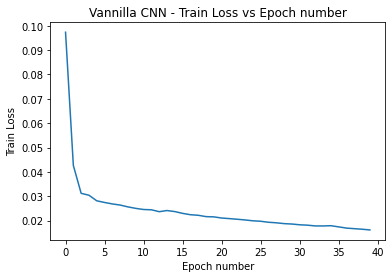

In [22]:
plt.plot(epoch_num, loss_arr)
plt.title('Vannilla CNN - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

#### Test

In [23]:
#def test(model,test_x,test_y):
def model_test(test_x,test_y, model, epoch_num=EPOCHS):
    model.train(False)
    correct = 0
    total = 0

    #print(test_y)
    with torch.no_grad():
        for i in tqdm(range(len(test_x))):
            real_class = test_y[i].to(dev)
            images=test_x[i].view(-1,3,256,256).to(dev)
            net_out = model(images) # returns a list, 

            predicted_class = torch.argmax(net_out,dim=1)
            #print(net_out," =>",predicted_class," : ",real_class)
            if predicted_class == real_class:
                correct += 1
                #print(net_out," =>",predicted_class," : ",real_class)
            total += 1
    print("Accuracy: ", round((correct/total)*100, 3)," % ")

In [24]:
vanillaCNN.train(False)
correct = 0
total = 0

#print(test_y)

with torch.no_grad():
    for i in tqdm(range(len(testX))):
        real_class = testY[i].to(dev)
        images=testX[i].view(-1,3,256,256).to(dev)
        net_out = vanillaCNN(images) # returns a list, 
        
        predicted_class = torch.argmax(net_out,dim=1)
        #print(net_out," =>",predicted_class," : ",real_class)
        #print(predicted_class.shape," : ",real_class.shape)
        if predicted_class == real_class:
            correct += 1
            #print(net_out," =>",predicted_class," : ",real_class)
        total += 1
print("Initial Model Accuracy: ", round((correct/total)*100, 3)," % ")

100%|██████████| 451/451 [00:00<00:00, 937.62it/s]

Initial Model Accuracy:  37.916  % 


### Model Train function

In [25]:
def model_train(model,trainX,trainY,testX,testY):
    trainX.to(dev)
    testX.to(dev)
    trainY.to(dev)
    testY.to(dev)
    model.to(dev)

    min_loss = np.Inf
    epoch_num=[]
    loss_arr=[]

    enum=0
    for epoch in range(EPOCHS):
        train_loss = 0
        model.train()

        for i in tqdm(range(0, len(trainX), BATCH_SIZE)): 
            #print(f"{i}:{i+BATCH_SIZE}")

            batch_X = trainX[i:i+BATCH_SIZE].to(dev)
            batch_y = trainY[i:i+BATCH_SIZE].to(dev)
            batch_y=batch_y.view(len(batch_y)).type(torch.LongTensor)

            # Clear accumulated gradients from previous iteration
            # before backpropagating. 
            model.zero_grad()
            batch_X=batch_X.cuda()
            batch_y=batch_y.cuda()
            #print(batch_X.shape)
            outputs = model(batch_X)
            outputs.to(dev)

            #print("result shape: ",outputs.shape,batch_y.shape)

            #print(outputs.dtype)
            #print(batch_y.dtype)

            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    #update weights

            #print(loss.item())
            #print(loss.item()," - ",len(train_x))
            train_loss += loss.item()/len(trainX)
        #print("train loss: ",train_loss)
        if epoch % 5 == 0:
            print('Epoch: {}, Train Loss: {:.4f}, Current Min Loss: {:.4f}\n'.format(   #print training loss at each step
                epoch,
                train_loss,
                min_loss
            )) 
        if train_loss < min_loss:   
            min_loss = train_loss
        epoch_num.append(enum)
        loss_arr.append(train_loss)
        enum+=1
    
    model_test(testX,testY, model, EPOCHS)

    return model,epoch_num,loss_arr

In [26]:
EPOCHS = 50
BATCH_SIZE = 100

In [27]:
trained_vanillaCNN, epoch_num,loss_arr = model_train(vanillaCNN, trainX,trainY,testX,testY)

100%|██████████| 19/19 [00:01<00:00, 16.07it/s]


Epoch: 0, Train Loss: 0.0162, Current Min Loss: inf



100%|██████████| 19/19 [00:01<00:00, 16.19it/s]


Epoch: 5, Train Loss: 0.0149, Current Min Loss: 0.0152



100%|██████████| 19/19 [00:01<00:00, 16.07it/s]


Epoch: 10, Train Loss: 0.0139, Current Min Loss: 0.0140



100%|██████████| 19/19 [00:01<00:00, 16.13it/s]


Epoch: 15, Train Loss: 0.0130, Current Min Loss: 0.0130



100%|██████████| 19/19 [00:01<00:00, 16.10it/s]


Epoch: 20, Train Loss: 0.0120, Current Min Loss: 0.0121



100%|██████████| 19/19 [00:01<00:00, 16.07it/s]


Epoch: 25, Train Loss: 0.0113, Current Min Loss: 0.0116



100%|██████████| 19/19 [00:01<00:00, 16.14it/s]


Epoch: 30, Train Loss: 0.0104, Current Min Loss: 0.0107



100%|██████████| 19/19 [00:01<00:00, 16.06it/s]


Epoch: 35, Train Loss: 0.0097, Current Min Loss: 0.0102



100%|██████████| 19/19 [00:01<00:00, 16.12it/s]


Epoch: 40, Train Loss: 0.0087, Current Min Loss: 0.0089



100%|██████████| 19/19 [00:01<00:00, 16.09it/s]


Epoch: 45, Train Loss: 0.0078, Current Min Loss: 0.0080



100%|██████████| 451/451 [00:00<00:00, 945.10it/s]

Accuracy:  39.246  % 


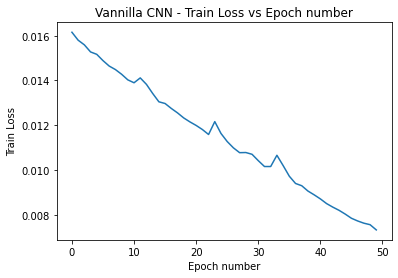

In [28]:
plt.plot(epoch_num, loss_arr)
plt.title('Vannilla CNN - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### ResNet18

In [29]:
resNet = models.resnet18(pretrained=True)

num_ftrs = resNet.fc.in_features
print(num_ftrs)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

512


In [30]:
import gc
gc.collect()

7409

In [31]:
resNet.fc = nn.Linear(num_ftrs, 11)
resNet.to(dev)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:


optimizer = optim.Adam(resNet.parameters(),lr=0.00001)
criterion = nn.CrossEntropyLoss().to(dev) 

In [33]:
trained_resNet, epoch_num,loss_arr = model_train(resNet, trainX,trainY,testX,testY)

100%|██████████| 19/19 [00:03<00:00,  5.82it/s]


Epoch: 0, Train Loss: 0.0287, Current Min Loss: inf



100%|██████████| 19/19 [00:03<00:00,  6.03it/s]


Epoch: 5, Train Loss: 0.0246, Current Min Loss: 0.0253



100%|██████████| 19/19 [00:03<00:00,  6.03it/s]


Epoch: 10, Train Loss: 0.0219, Current Min Loss: 0.0224



100%|██████████| 19/19 [00:03<00:00,  6.02it/s]


Epoch: 15, Train Loss: 0.0198, Current Min Loss: 0.0202



100%|██████████| 19/19 [00:03<00:00,  6.02it/s]


Epoch: 20, Train Loss: 0.0179, Current Min Loss: 0.0183



100%|██████████| 19/19 [00:03<00:00,  6.02it/s]


Epoch: 25, Train Loss: 0.0163, Current Min Loss: 0.0166



100%|██████████| 19/19 [00:03<00:00,  6.01it/s]


Epoch: 30, Train Loss: 0.0148, Current Min Loss: 0.0151



100%|██████████| 19/19 [00:03<00:00,  6.01it/s]


Epoch: 35, Train Loss: 0.0134, Current Min Loss: 0.0137



100%|██████████| 19/19 [00:03<00:00,  6.01it/s]


Epoch: 40, Train Loss: 0.0123, Current Min Loss: 0.0125



100%|██████████| 19/19 [00:03<00:00,  6.00it/s]


Epoch: 45, Train Loss: 0.0111, Current Min Loss: 0.0113



100%|██████████| 451/451 [00:01<00:00, 283.08it/s]

Accuracy:  47.45  % 


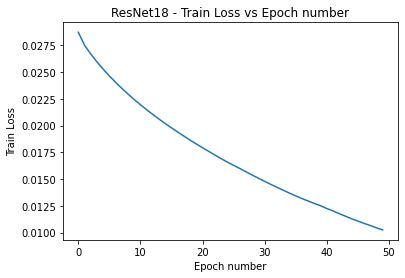

In [34]:
plt.plot(epoch_num, loss_arr)
plt.title('ResNet18 - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### AlexNet

In [35]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=11):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 12 * 12, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        #print("conv output shape: ",x.shape)
        x = x.reshape(x.size(0), 256 * 12 * 12)
        x = F.log_softmax(self.classifier(x),dim=1)
        return x

In [36]:
alexNet=AlexNet(11)

In [37]:
alexNet.to(dev)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=36864, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
  

In [38]:
optimizer = optim.Adam(alexNet.parameters(),lr=0.00001)

In [39]:
print(img.shape)
b=alexNet(img)
print("batch result: ",b.shape)
b

torch.Size([19, 3, 256, 256])
batch result:  torch.Size([19, 11])


tensor([[-2.8073, -2.9315, -2.4640, -2.5239, -2.2502, -2.7749, -2.5429, -2.6698,
         -2.6377, -1.7334, -1.8500],
        [-2.8423, -2.8584, -2.1958, -2.5823, -2.4693, -2.4968, -2.4225, -1.8817,
         -2.4619, -2.2377, -2.3282],
        [-2.9755, -2.8031, -2.0503, -1.9792, -2.3573, -2.6264, -2.3392, -2.4145,
         -2.7019, -2.0668, -2.5904],
        [-3.0117, -2.7346, -2.2278, -2.0932, -2.2046, -2.6403, -2.6908, -2.1950,
         -2.9480, -1.9892, -2.2563],
        [-2.7551, -2.8758, -2.4142, -2.4149, -2.2113, -2.2832, -2.9865, -2.4204,
         -2.2202, -1.9815, -2.2643],
        [-2.6469, -2.6286, -2.2461, -2.2323, -2.5313, -2.3539, -2.5621, -2.6454,
         -2.3398, -2.2051, -2.1662],
        [-2.5042, -2.1519, -2.5679, -2.3476, -2.3829, -2.3001, -2.4775, -2.4072,
         -2.6415, -2.4077, -2.2839],
        [-3.0547, -2.8613, -2.3264, -2.0578, -2.4709, -2.3712, -2.3000, -2.4276,
         -2.3048, -2.1352, -2.4546],
        [-2.7651, -2.8305, -2.5418, -1.8898, -2.1259, -2

In [40]:
trained_alexNet , epoch_num,loss_arr= model_train(alexNet, trainX,trainY,testX,testY)

100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


Epoch: 0, Train Loss: 0.0456, Current Min Loss: inf



100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


Epoch: 5, Train Loss: 0.0240, Current Min Loss: 0.0244



100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


Epoch: 10, Train Loss: 0.0215, Current Min Loss: 0.0219



100%|██████████| 19/19 [00:02<00:00,  6.49it/s]


Epoch: 15, Train Loss: 0.0199, Current Min Loss: 0.0199



100%|██████████| 19/19 [00:02<00:00,  6.49it/s]


Epoch: 20, Train Loss: 0.0196, Current Min Loss: 0.0183



100%|██████████| 19/19 [00:02<00:00,  6.51it/s]


Epoch: 25, Train Loss: 0.0169, Current Min Loss: 0.0165



100%|██████████| 19/19 [00:02<00:00,  6.49it/s]


Epoch: 30, Train Loss: 0.0162, Current Min Loss: 0.0153



100%|██████████| 19/19 [00:02<00:00,  6.49it/s]


Epoch: 35, Train Loss: 0.0141, Current Min Loss: 0.0138



100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


Epoch: 40, Train Loss: 0.0123, Current Min Loss: 0.0123



100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


Epoch: 45, Train Loss: 0.0110, Current Min Loss: 0.0103



100%|██████████| 451/451 [00:00<00:00, 498.55it/s]

Accuracy:  53.88  % 


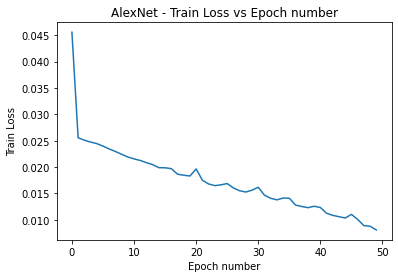

In [41]:
plt.plot(epoch_num, loss_arr)
plt.title('AlexNet - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### Pretrained on ImageNet AlexNet

In [42]:
pretrained_AlexNet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [43]:
#pretrained_AlexNet

In [44]:
num_ftrs = pretrained_AlexNet.classifier[6].in_features
num_ftrs

4096

In [45]:
pretrained_AlexNet.classifier[6]= nn.Linear(num_ftrs, 11)
pretrained_AlexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [46]:
optimizer = optim.Adam(pretrained_AlexNet.parameters(),lr=0.00001)

In [47]:
EPOCHS = 40
BATCH_SIZE = 200

In [48]:
retrained_AlexNet, epoch_num,loss_arr = model_train(pretrained_AlexNet, trainX,trainY,testX,testY)

100%|██████████| 10/10 [00:01<00:00,  7.30it/s]


Epoch: 0, Train Loss: 0.1503, Current Min Loss: inf



100%|██████████| 10/10 [00:01<00:00,  7.38it/s]


Epoch: 5, Train Loss: 0.0303, Current Min Loss: 0.0341



100%|██████████| 10/10 [00:01<00:00,  7.37it/s]


Epoch: 10, Train Loss: 0.0172, Current Min Loss: 0.0192



100%|██████████| 10/10 [00:01<00:00,  7.38it/s]


Epoch: 15, Train Loss: 0.0128, Current Min Loss: 0.0133



100%|██████████| 10/10 [00:01<00:00,  7.37it/s]


Epoch: 20, Train Loss: 0.0100, Current Min Loss: 0.0099



100%|██████████| 10/10 [00:01<00:00,  7.37it/s]


Epoch: 25, Train Loss: 0.0085, Current Min Loss: 0.0085



100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


Epoch: 30, Train Loss: 0.0068, Current Min Loss: 0.0074



100%|██████████| 10/10 [00:01<00:00,  7.37it/s]


Epoch: 35, Train Loss: 0.0061, Current Min Loss: 0.0064



100%|██████████| 451/451 [00:00<00:00, 647.39it/s]

Accuracy:  54.545  % 


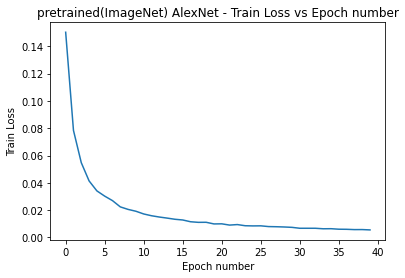

In [49]:
plt.plot(epoch_num, loss_arr)
plt.title('pretrained(ImageNet) AlexNet - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### VGG16

In [50]:
vgg16 = models.vgg16()

In [51]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [52]:
num_ftrs = vgg16.classifier[0].in_features
num_ftrs

25088

In [53]:
vgg16.classifier=nn.Sequential(nn.Linear(num_ftrs,1000),  nn.ReLU(inplace=True),nn.Dropout(0.5,inplace=True),nn.Linear(1000, out_features=11, bias=True))

In [54]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [55]:
optimizer = optim.Adam(vgg16.parameters(),lr=0.00001)

In [56]:
EPOCHS = 40
BATCH_SIZE = 2

In [57]:
gc.collect()

7881

In [58]:
trained_vgg16, epoch_num,loss_arr = model_train(vgg16, trainX,trainY,testX,testY)

  0%|          | 0/902 [00:00<?, ?it/s]


RuntimeError: ignored

Tried reducing BATCH_SIZE and I still get this error, so model will be skipped :(

### GoogLeNet

In [59]:
googLeNet=torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [60]:
#googLeNet

In [61]:
num_ftrs = googLeNet.fc.in_features
num_ftrs

1024

In [62]:
googLeNet.fc= nn.Linear(num_ftrs, 11)
#googLeNet

In [63]:
optimizer = optim.Adam(googLeNet.parameters(),lr=0.00001)

In [64]:
BATCH_SIZE = 2
EPOCHS = 65

In [65]:
trained_googLeNet, epoch_num,loss_arr = model_train(googLeNet, trainX,trainY,testX,testY)

  0%|          | 0/902 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 902/902 [00:38<00:00, 23.35it/s]


Epoch: 0, Train Loss: 1.2319, Current Min Loss: inf



100%|██████████| 902/902 [00:38<00:00, 23.36it/s]


Epoch: 5, Train Loss: 1.0938, Current Min Loss: 1.0587



100%|██████████| 902/902 [00:40<00:00, 22.54it/s]


Epoch: 10, Train Loss: 1.0220, Current Min Loss: 1.0587



100%|██████████| 902/902 [00:39<00:00, 22.71it/s]


Epoch: 15, Train Loss: 0.8071, Current Min Loss: 0.8469



100%|██████████| 902/902 [00:38<00:00, 23.49it/s]


Epoch: 20, Train Loss: 0.6389, Current Min Loss: 0.6704



100%|██████████| 902/902 [00:38<00:00, 23.45it/s]


Epoch: 25, Train Loss: 0.4856, Current Min Loss: 0.5136



100%|██████████| 902/902 [00:38<00:00, 23.58it/s]


Epoch: 30, Train Loss: 0.3537, Current Min Loss: 0.3764



100%|██████████| 902/902 [00:38<00:00, 23.62it/s]


Epoch: 35, Train Loss: 0.2592, Current Min Loss: 0.2736



100%|██████████| 902/902 [00:38<00:00, 23.63it/s]


Epoch: 40, Train Loss: 0.1872, Current Min Loss: 0.1957



100%|██████████| 902/902 [00:36<00:00, 24.53it/s]


Epoch: 45, Train Loss: 0.1267, Current Min Loss: 0.1350



100%|██████████| 902/902 [00:37<00:00, 24.16it/s]


Epoch: 50, Train Loss: 0.1036, Current Min Loss: 0.1059



100%|██████████| 902/902 [00:36<00:00, 24.78it/s]


Epoch: 55, Train Loss: 0.0839, Current Min Loss: 0.0883



100%|██████████| 902/902 [00:37<00:00, 24.37it/s]


Epoch: 60, Train Loss: 0.0657, Current Min Loss: 0.0719



100%|██████████| 451/451 [00:04<00:00, 102.66it/s]

Accuracy:  0.222  % 


In [66]:
model_test(testX,testY, trained_googLeNet, epoch_num=EPOCHS)

  0%|          | 0/451 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 451/451 [00:04<00:00, 101.52it/s]

Accuracy:  0.222  % 


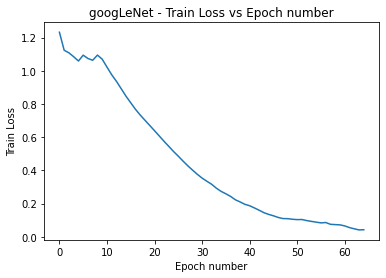

In [67]:
plt.plot(epoch_num, loss_arr)
plt.title('googLeNet - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### ResNet34

In [68]:
#resNext50 = models.resnext50_32x4d(pretrained=True)
resNet34=models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [69]:
resNet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [70]:
num_ftrs = resNet34.fc.in_features
num_ftrs

512

In [71]:
resNet34.fc= nn.Linear(num_ftrs, 11)

In [72]:
optimizer = optim.Adam(resNet34.parameters(),lr=0.00001)

In [73]:
BATCH_SIZE = 100
EPOCHS = 80

In [74]:
trained_resNet34, epoch_num,loss_arr = model_train(resNet34, trainX,trainY,testX,testY)

100%|██████████| 19/19 [00:05<00:00,  3.43it/s]


Epoch: 0, Train Loss: 0.0261, Current Min Loss: inf



100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


Epoch: 5, Train Loss: 0.0209, Current Min Loss: 0.0216



100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


Epoch: 10, Train Loss: 0.0177, Current Min Loss: 0.0183



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 15, Train Loss: 0.0150, Current Min Loss: 0.0155



100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


Epoch: 20, Train Loss: 0.0127, Current Min Loss: 0.0131



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 25, Train Loss: 0.0105, Current Min Loss: 0.0109



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 30, Train Loss: 0.0090, Current Min Loss: 0.0093



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 35, Train Loss: 0.0074, Current Min Loss: 0.0077



100%|██████████| 451/451 [00:02<00:00, 176.91it/s]

Accuracy:  46.563  % 


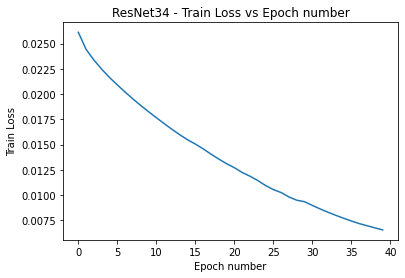

In [75]:
plt.plot(epoch_num, loss_arr)
plt.title('ResNet34 - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

In [90]:
len(loss_arr)

50

### ResNext 50 32x4d

In [81]:
resNext50=models.resnext50_32x4d(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [82]:
resNext50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [83]:
num_ftrs = resNext50.fc.in_features
num_ftrs

2048

In [84]:
resNext50.fc = nn.Linear(num_ftrs, 11)

In [85]:
optimizer = optim.Adam(resNext50.parameters(),lr=0.00001)

In [86]:
BATCH_SIZE = 5
EPOCHS = 50

In [87]:

gc.collect()

7937

In [88]:
trained_resNext50, epoch_num,loss_arr = model_train(resNext50, trainX,trainY,testX,testY)

100%|██████████| 361/361 [00:31<00:00, 11.63it/s]


Epoch: 0, Train Loss: 0.5112, Current Min Loss: inf



100%|██████████| 361/361 [00:31<00:00, 11.58it/s]


Epoch: 5, Train Loss: 0.3742, Current Min Loss: 0.3906



100%|██████████| 361/361 [00:31<00:00, 11.64it/s]


Epoch: 10, Train Loss: 0.3412, Current Min Loss: 0.3345



100%|██████████| 361/361 [00:30<00:00, 11.70it/s]


Epoch: 15, Train Loss: 0.2575, Current Min Loss: 0.2701



100%|██████████| 361/361 [00:30<00:00, 11.67it/s]


Epoch: 20, Train Loss: 0.2090, Current Min Loss: 0.2161



100%|██████████| 361/361 [00:31<00:00, 11.64it/s]


Epoch: 25, Train Loss: 0.1631, Current Min Loss: 0.1727



100%|██████████| 361/361 [00:30<00:00, 11.66it/s]


Epoch: 30, Train Loss: 0.1130, Current Min Loss: 0.1232



100%|██████████| 361/361 [00:30<00:00, 11.66it/s]


Epoch: 35, Train Loss: 0.0937, Current Min Loss: 0.1020



100%|██████████| 361/361 [00:31<00:00, 11.63it/s]


Epoch: 40, Train Loss: 0.0533, Current Min Loss: 0.0598



100%|██████████| 361/361 [00:30<00:00, 11.68it/s]


Epoch: 45, Train Loss: 0.0421, Current Min Loss: 0.0425



100%|██████████| 451/451 [00:04<00:00, 106.78it/s]

Accuracy:  1.33  % 


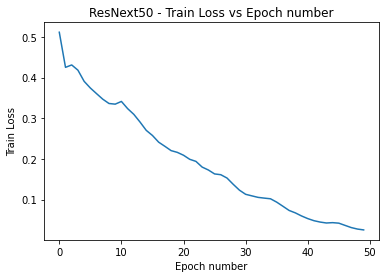

In [89]:
plt.plot(epoch_num, loss_arr)
plt.title('ResNext50 - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### Resources

- https://competitions.codalab.org/competitions/4081#participate-get-data
- 


- https://blog.keras.io/running-jupyter-notebooks-on-gpu-on-aws-a-starter-guide.html

##### 